# Rice Growth Simulation for Koshimizu, Niigata
Using PCSE/WOFOST for simulating paddy rice growth

In [175]:
# Import required packages
import os
from datetime import date
import pcse
from pcse.models import Wofost72_WLP_CWB
from pcse.fileinput import YAMLCropDataProvider
from nasapower_fixed import NASAPowerWeatherDataProvider
from pcse.base import ParameterProvider
from pcse.input import YAMLAgroManagementReader
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Setup Weather Data
Get weather data from NASA POWER database for Koshimizu

In [176]:
# Initialize weather data provider
wdp = NASAPowerWeatherDataProvider(latitude=37.86305, longitude=139.04025)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:   21.6
Latitude:  37.863
Longitude: 139.040
Data available for 1984-01-01 - 2024-10-29
Number of missing days: 3



## 2. Define Soil Parameters
Parameters for paddy soil conditions

In [177]:
# Soil parameters for paddy conditions
soil_params = {
    # Site parameters
    'IFUNRN': 0,       # No infiltration function
    'NOTINF': 0,       # No surface water influence
    
    # Soil moisture content parameters
    'SMW': 0.15,       # Wilting point 
    'SMFCF': 0.35,     # Field capacity
    'SM0': 0.50,       # Saturation point
    'CRAIRC': 0.05,    # Critical air content
    
    # Hydraulic parameters for paddy conditions
    'K0': 10.0,        # Hydraulic conductivity (cm/day)
    'SOPE': 5.0,       # Maximum percolation rate (cm/day)
    'KSUB': 10.0,      # Hydraulic conductivity subsoil (cm/day)
    
    # Physical parameters  
    'RDMSOL': 40.0,    # Maximum rooting depth in soil (cm)
    'SOILTYPE': 1,     # Type of soil (1 for loam)
    
    # Initial conditions
    'WAV': 100,        # Initial soil water availability (% of WHC)
    'ZTI': 0.0,         # Initial groundwater level (cm)

    'SMLIM': 0.3,      # Lower limit for soil moisture content
    'SSI': 0.0,        # Initial soil moisture content
    'SSMAX': 0.0,      # Maximum soil moisture content
    'SSMIN': 0.0,      # Minimum soil moisture content
    'REALLOC_DVS': 0.0, # Reallocation factor
    'REALLOC_EFFICIENCY': 0.0, # Reallocation efficiency
    'REALLOC_LEAF_FRACTION': 0.0, # Reallocation leaf fraction
    'REALLOC_LEAF_RATE': 0.0, # Reallocation leaf rate
    'REALLOC_STEM_FRACTION': 0.0, # Reallocation stem fraction
    'REALLOC_STEM_RATE': 0.0, # Reallocation stem rate
    'AMAX_LNB': 0.0, # Maximum leaf nitrogen content
}

## 3. Setup Crop Parameters
Get default rice parameters from PCSE

In [178]:
# Get crop parameters for rice
crop_data = YAMLCropDataProvider()
crop_data.set_active_crop('rice', 'Rice_501')

# Combine parameters
parameters = ParameterProvider(cropdata=crop_data, soildata=soil_params)

## 4. Define Agromanagement
Setup rice growing calendar and irrigation for Niigata conditions

In [179]:
# Define agromanagement 
agro_management = """
Version: 1.0
AgroManagement:
- 2024-01-01:
    CropCalendar:
        crop_name: rice
        variety_name: Rice_501
        crop_start_date: 2024-01-01
        crop_start_type: emergence
        crop_end_date: 2024-05-30
        crop_end_type: harvest
        max_duration: 150
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation Schedule
        comment: Keep paddy field flooded
        events_table:
        - 2024-05-01: {amount: 5, efficiency: 0.95}
    StateEvents: null
"""

# Save and read agromanagement
with open("rice_calendar.agro", "w") as f:
    f.write(agro_management)

agromanagement = YAMLAgroManagementReader("rice_calendar.agro")

## 5. Run Simulation

In [180]:
# Initialize and run WOFOST
wofost = Wofost72_WLP_CWB(parameters, wdp, agromanagement)
wofost.run_till_terminate()

# Get results
results = wofost.get_output()
df_results = pd.DataFrame(results).set_index("day")

# Print key results
print("\nSimulation Results:")
print(f"Final Total Biomass: {df_results['TAGP'].iloc[-1]:.0f} kg/ha")
print(f"Final Yield: {df_results['TWSO'].iloc[-1]:.0f} kg/ha")
print(f"Maximum LAI: {df_results['LAI'].max():.1f}")


Simulation Results:
Final Total Biomass: 767 kg/ha
Final Yield: 0 kg/ha
Maximum LAI: 0.6


## 6. Visualize Results

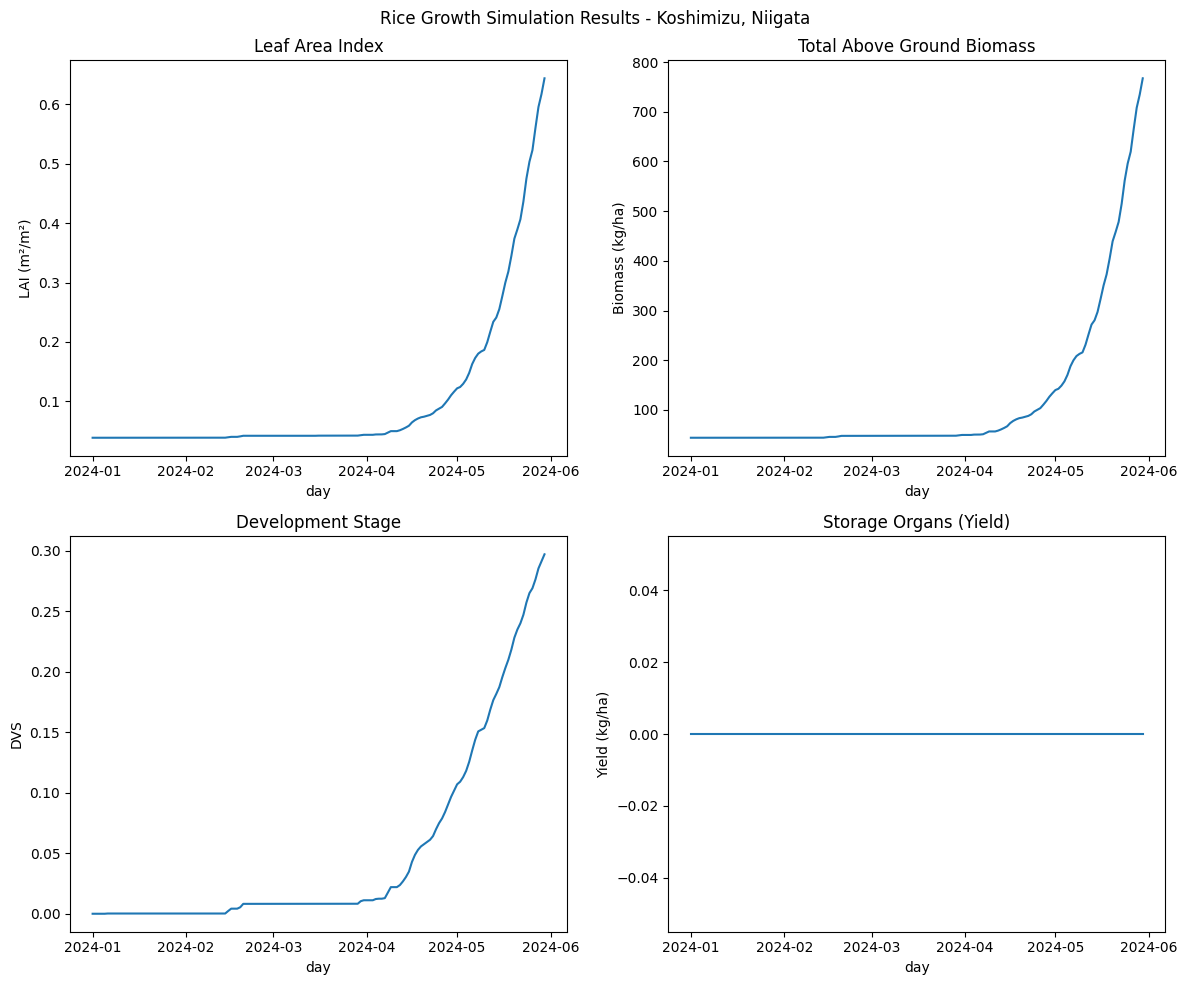

In [181]:
# Plot key variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.suptitle('Rice Growth Simulation Results - Koshimizu, Niigata')

# Plot LAI
df_results['LAI'].plot(ax=axes[0,0], title='Leaf Area Index')
axes[0,0].set_ylabel('LAI (m²/m²)')

# Plot Total Biomass
df_results['TAGP'].plot(ax=axes[0,1], title='Total Above Ground Biomass')
axes[0,1].set_ylabel('Biomass (kg/ha)')

# Plot Development Stage
df_results['DVS'].plot(ax=axes[1,0], title='Development Stage')
axes[1,0].set_ylabel('DVS')

# Plot Storage Organs (Yield)
df_results['TWSO'].plot(ax=axes[1,1], title='Storage Organs (Yield)')
axes[1,1].set_ylabel('Yield (kg/ha)')

plt.tight_layout()
plt.show()